Running a Tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def true_process(mu: float = 0.0, N: int = 500):
  x = 5 * rng.normal(size=N, loc=mu)
  f_x = x / np.e - np.pi
  y = np.maximum(0.0, f_x + rng.normal(size=N))
  y_ideal = np.maximum(0.0, f_x)
  df = pd.DataFrame({'x': x, 'y': y, 'y_ideal': y_ideal})
  return df

d_train = true_process()
d_test = true_process()


d_train.head()

,x,y,y_ideal
0,5.144284,0.000000,0.0
1,8.209600,0.057061,0.0
2,5.733598,0.000000,0.0
3,-4.865898,0.000000,0.0
4,-6.964000,0.000000,0.0


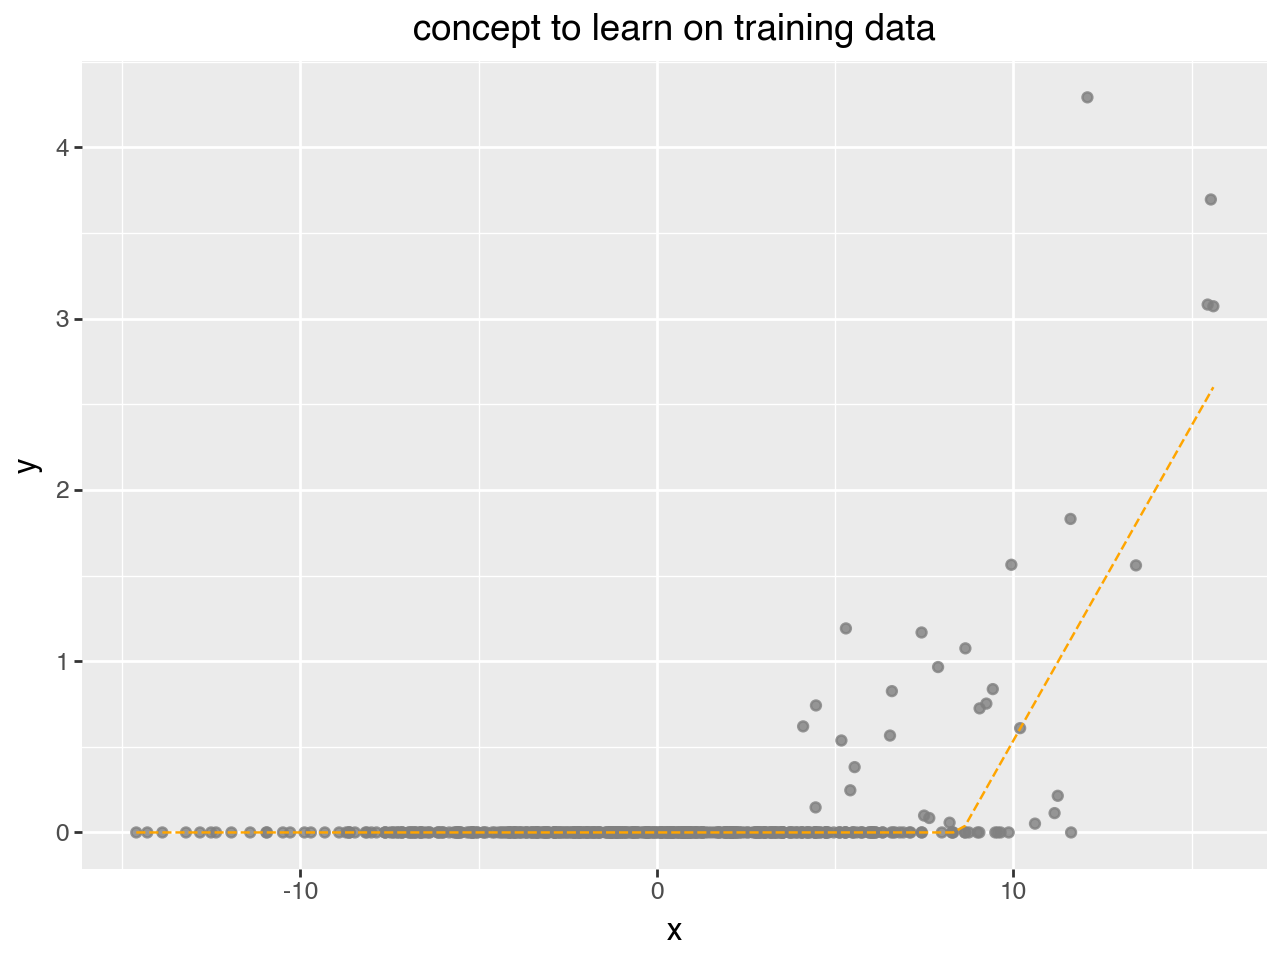

In [4]:
(
    ggplot(
        data=d_train, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("concept to learn on training data")
)

In [5]:

lm0 = LinearRegression()
lm0.fit(
    d_train.loc[:, ['x']],
    d_train.loc[:, 'y'],
)

d_test['ypred0'] = np.maximum(0, lm0.predict(d_test.loc[:, ['x']]))

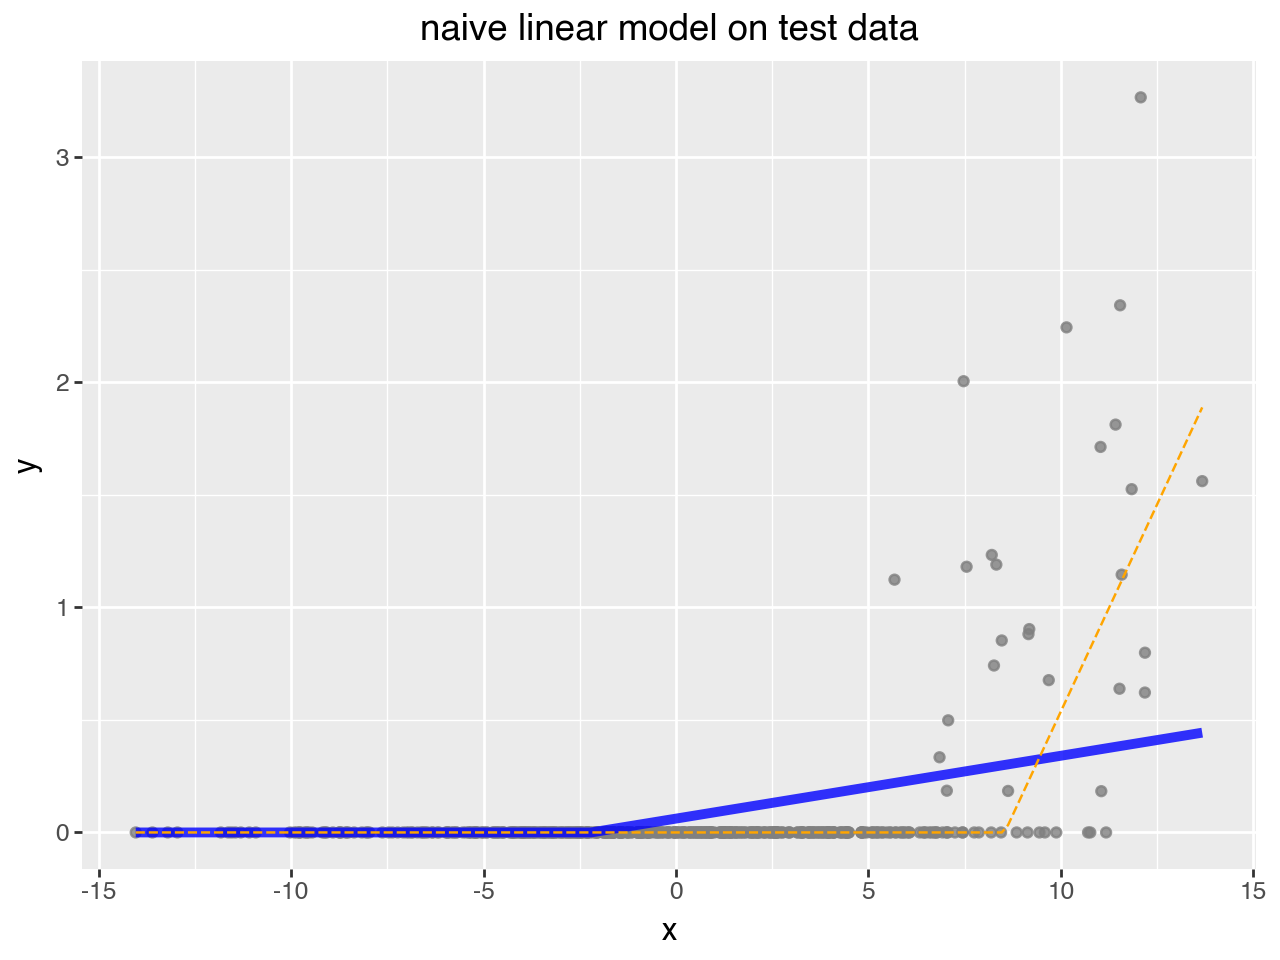

In [6]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue",
        alpha=0.8,
        size=2) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("naive linear model on test data")
)

In [7]:
stan_model_src = """
data {
  int<lower=0> N_positive;   // number of positive observations
  int<lower=0> N_zero;       // number of zeros observations
  vector[N_positive] x_pos;  // observed predictions (to be adjusted to match outcomes)
  vector[N_positive] y_pos;  // observed outcomes
  vector[N_zero] x_zero;     // observed predictions (to be adjusted to match zero outcomes)
}
parameters {
  real a;               // regression slope
  real b;               // regression intercept
  real<lower=0> sigma;  // variance
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(1);
      // Tobit style model structure
  target += normal_lpdf(y_pos | a * x_pos + b, sigma);
  target += normal_lcdf( 0 | a * x_zero + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

In [8]:
pos_positions = d_train['y'] > 0
x_pos = list(d_train['x'][pos_positions])
y_pos = list(d_train['y'][pos_positions])
x_zero = list(d_train['x'][pos_positions == False])

In [9]:
# build model
stan_file = 'tobit_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)

model

CmdStanModel: name=tobit_tmp
	 stan_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp.stan
	 exe_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp
	 compiler_options=stanc_options={}, cpp_options={}

In [10]:
data_str = f"""
{{
    "N_positive" : {len(x_pos)},
    "N_zero" : {len(x_zero)},
    "x_pos" : {x_pos},
    "y_pos" : {y_pos},
    "x_zero" : {x_zero}
}}
"""

print(data_str)


{
    "N_positive" : 29,
    "N_zero" : 471,
    "x_pos" : [8.209600203355752, 9.051427871476417, 9.240836476605333, 11.24404037552951, 11.601766903831074, 5.174750751759538, 9.421298500459269, 7.639793908700696, 9.941866985494224, 4.4509823278475515, 12.07567073917814, 4.461256969254047, 5.546046908276275, 11.154403671975764, 6.538006500360501, 7.88664881757817, 6.591156391438304, 10.18806068239848, 15.607969164461009, 7.423622860700116, 5.424522634122317, 5.301233731950853, 4.101114414042877, 15.448730493283175, 13.437867813499134, 10.60474887217886, 15.53831593012524, 7.494045802220172, 8.652580126751694],
    "y_pos" : [0.057061009819637826, 0.7245462717673496, 0.752461613419922, 0.21408572447417507, 1.8307950096300742, 0.5371082827330906, 0.8370934181402299, 0.08445091252906856, 1.5631537376008022, 0.14627037073440197, 4.292681607830632, 0.7416455705669829, 0.381567387452709, 0.11295057687192112, 0.5658274913549706, 0.9658582066392327, 0.8252254550990406, 0.6091566506662998, 3.07

In [11]:
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [12]:
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
    )

In [13]:
res = fit.draws_pd()

In [14]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0,-74.9935,0.999017,0.217532,4.0,19.0,0.0,75.5361,0.405242,-3.61432,1.09261
1,-75.0063,0.996612,0.217532,5.0,31.0,0.0,76.2116,0.403324,-3.61515,1.15852
2,-76.7655,0.947426,0.217532,2.0,7.0,0.0,78.5457,0.364524,-3.53214,1.29220
3,-78.0073,0.999172,0.217532,4.0,23.0,0.0,78.7304,0.574212,-5.15803,1.31540
4,-77.5335,0.932403,0.217532,3.0,7.0,0.0,79.0489,0.557320,-5.04490,1.55246
...,...,...,...,...,...,...,...,...,...,...
3995,-77.0620,1.000000,0.236119,3.0,7.0,0.0,78.1651,0.385195,-3.60757,1.35651
3996,-74.9090,0.912759,0.236119,2.0,7.0,0.0,79.5560,0.427756,-3.82956,1.15860
3997,-75.0555,0.952532,0.236119,3.0,15.0,0.0,75.2126,0.401288,-3.68723,1.15600
3998,-75.1421,0.999741,0.236119,3.0,15.0,0.0,75.4587,0.459687,-4.16634,1.22719


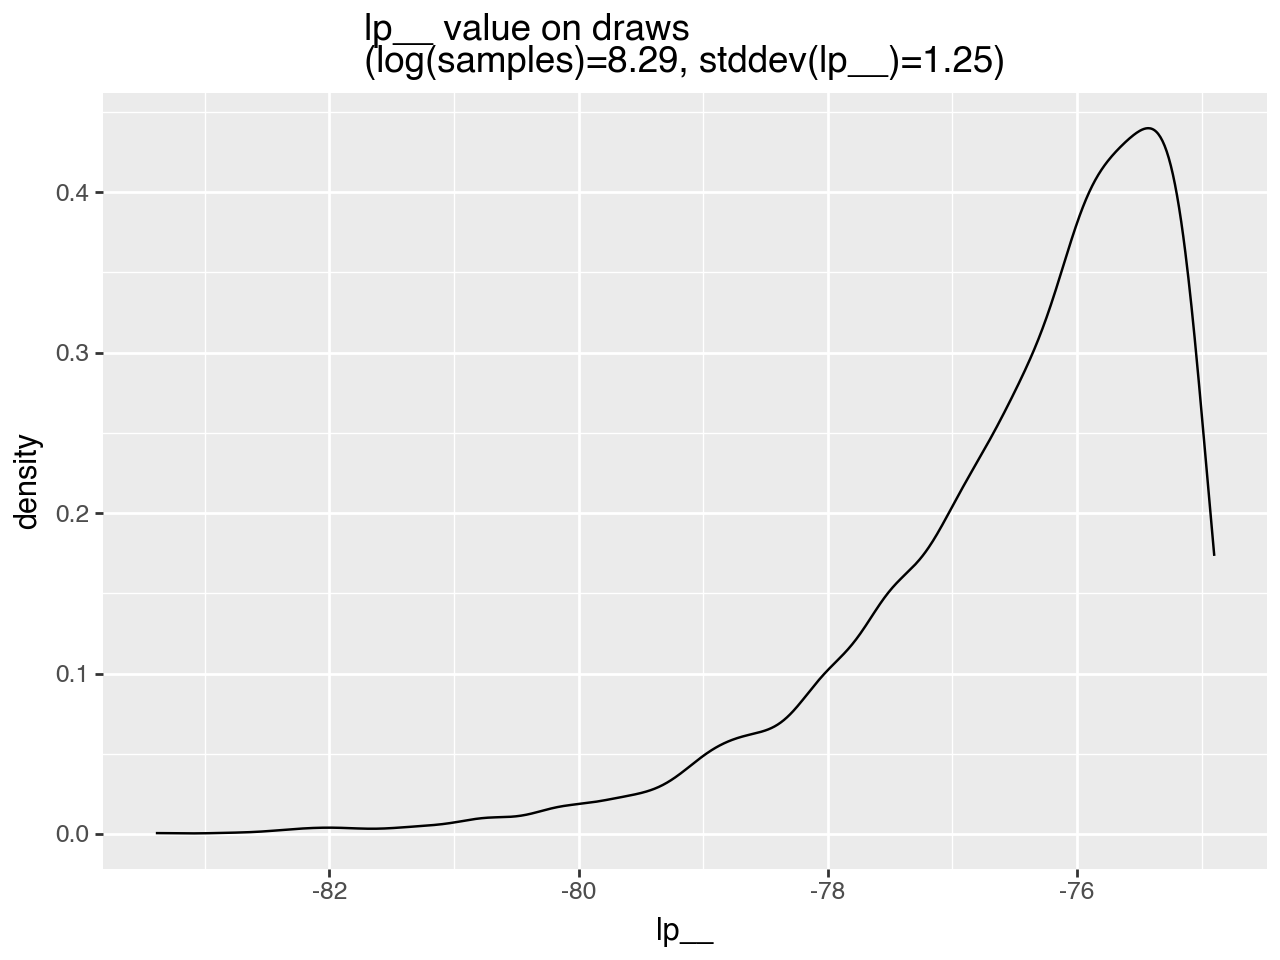

In [15]:
log_n_res = np.log(res.shape[0])
std_lp = np.std(res['lp__'])
(
    ggplot(
        data=res,
        mapping=aes(x='lp__'),
    )
    + geom_density()
    + ggtitle(f"lp__ value on draws\n(log(samples)={log_n_res:.2f}, stddev(lp__)={std_lp:.2f})")
)

In [16]:

res_picked = res.loc[res['lp__'] >= np.quantile(res['lp__'], q=0.9), :].reset_index(drop=True, inplace=False)




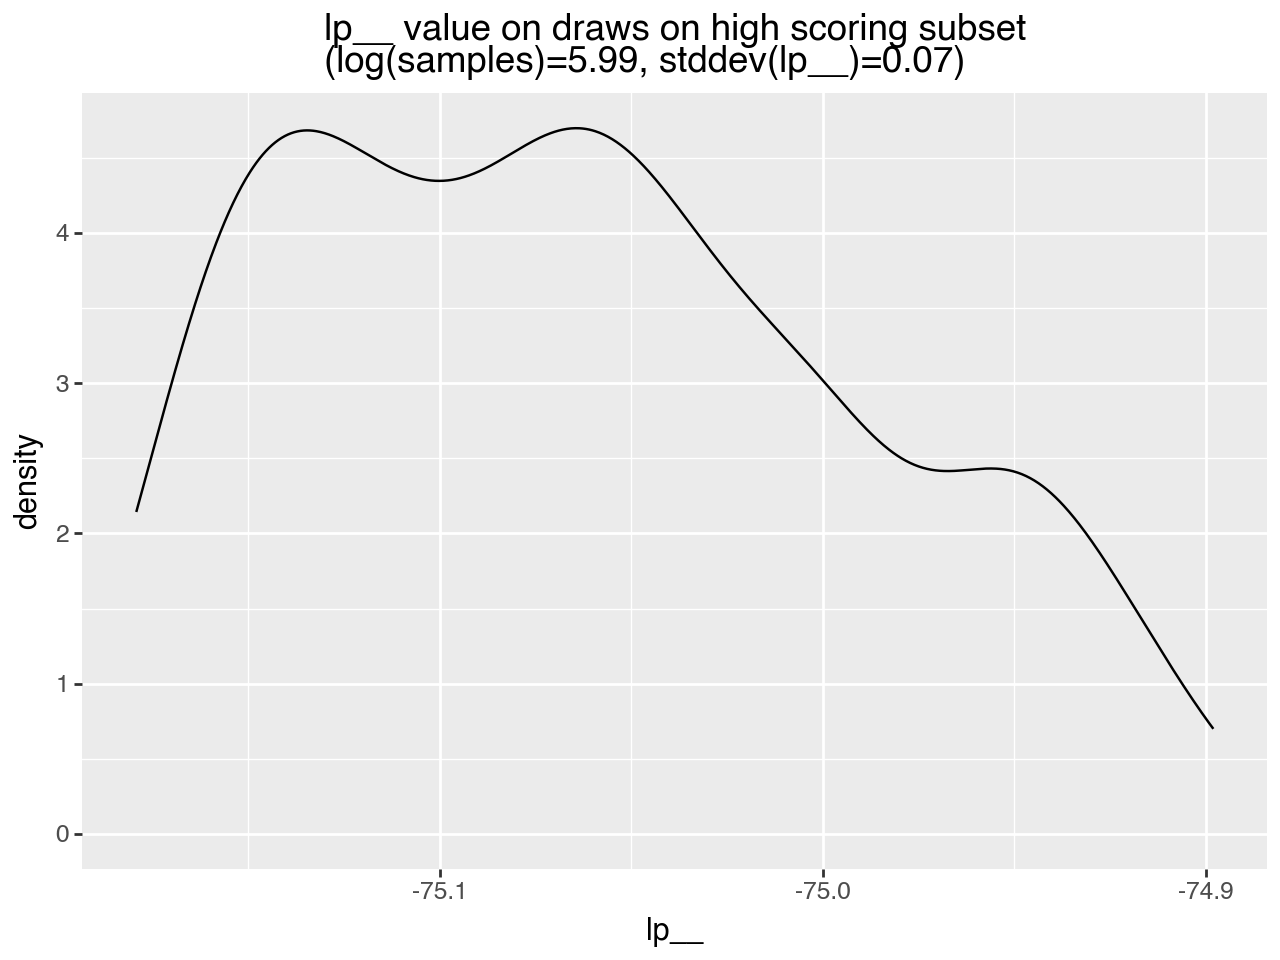

In [17]:
log_n_res_picked = np.log(res_picked.shape[0])
std_lp_picked = np.std(res_picked['lp__'])
(
    ggplot(
        data=res_picked,
        mapping=aes(x='lp__'),
    )
    + geom_density()
    + ggtitle(f"lp__ value on draws on high scoring subset\n(log(samples)={log_n_res_picked:.2f}, stddev(lp__)={std_lp_picked:.2f})")
)

In [18]:
a = res_picked['a'].mean()
b = res_picked['b'].mean()

(a, b)

(0.42378604, -3.808153375)

In [19]:
d_test['Tobit prediction'] = np.maximum(0, a * d_test['x'] + b)

d_test

,x,y,y_ideal,ypred0,Tobit prediction
0,4.405202,0.0,0.000000,0.184550,0.000000
1,-4.219999,0.0,0.000000,0.000000,0.000000
2,-9.852595,0.0,0.000000,0.000000,0.000000
3,2.086173,0.0,0.000000,0.119784,0.000000
4,-6.202299,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...
495,2.908689,0.0,0.000000,0.142755,0.000000
496,-5.229208,0.0,0.000000,0.000000,0.000000
497,-3.406794,0.0,0.000000,0.000000,0.000000
498,10.707725,0.0,0.797559,0.360568,0.729631


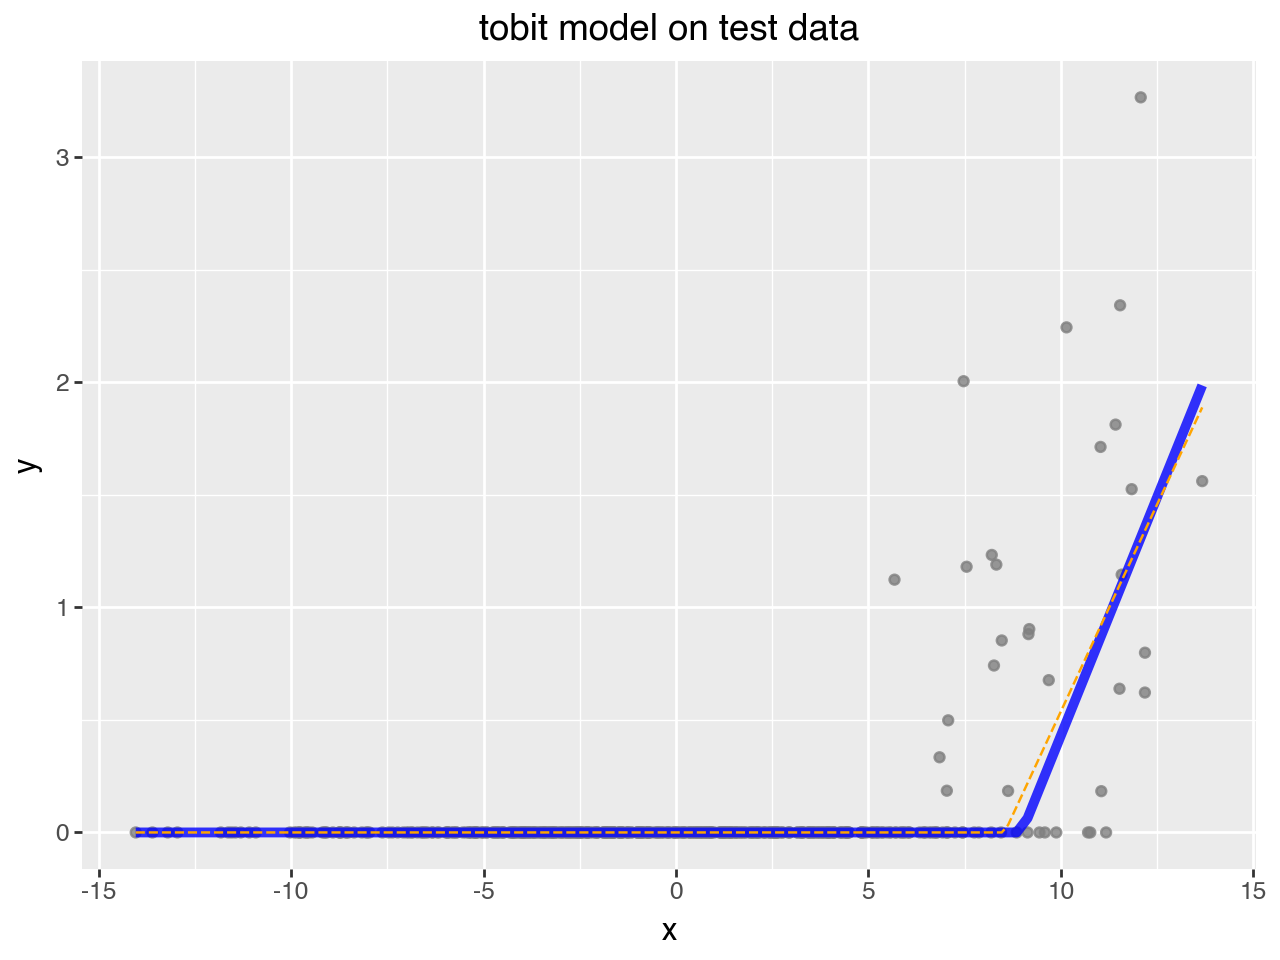

In [20]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='Tobit prediction'),
        color="blue",
        alpha=0.8,
        size=2) +
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("tobit model on test data")
)